Plots win rate and score margins throughout training.

In [1]:
from typing import Dict, Iterable, List, Mapping, Optional, Tuple

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import scipy.stats as st

import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

In [2]:
def get_victim_active_ranges(df: pd.DataFrame) -> Dict[str, Tuple[int, int]]:
    """Get victims' active ranges during training."""
    df = df[df.gtype == "normal"]
    df = df[df.board_size == 19]
    df["victim_name_v2"] = (
        df.victim_name.str.strip("kata1-").str.strip(".bin.gz").str.strip(".txt.gz")
        + "-v"
        + df.victim_visits.astype("str")
    )

    grouped_df = df[["victim_name_v2", "adv_steps"]].groupby("victim_name_v2")
    min_dict = grouped_df.adv_steps.min()
    max_dict = grouped_df.adv_steps.max()

    victim_ranges: Dict[str, Tuple[int, int]] = {}
    for v in df.victim_name_v2.unique():
        start = min_dict[v]
        end = max_dict[v]
        victim_ranges[v] = (start, end)
    victim_ranges = dict(sorted(victim_ranges.items(), key=lambda x: x[1][1]))
    return victim_ranges


def get_victim_change_steps(df: pd.DataFrame) -> List[int]:
    """Get steps at which victim changes during training."""
    return [r[0] for r in get_victim_active_ranges(df).values()]


def plot_training(
    df: pd.DataFrame,
    victim_name_to_plot_label: Mapping[str, str],
    highlighted_point_step: int,
    victim_change_steps: Iterable[int],
    board_size: int = 19,
    ignored_adversaries: Optional[List] = None,
    legend_ncol: Optional[int] = None,
    wr_or_scorediff: Optional[str] = 'wr'
) -> Tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot win rate or score margin throughout training.

    Params:
        df: Data
        victim_name_to_plot_label: Key = victims to plot, value = label on plot legend
        highlighted_point_step: Point (specified by adversary training steps) to mark
          with a special marker on the plot
        victim_changes_steps: Training steps at which the victim changed
        plot_name: Filename of plot
        ignored_adversaries: Names of adversaries to ignore due to bad data
        legend_ncol: Override the number of legend_columns
        wr_or_scorediff: plot wr (winrate), scorediff (margin of victory), 
          scorediff_advin (margin when adversary wins), or scorediff_advlose (margin when it loses)
    """
    assert wr_or_scorediff in ['wr','scorediff','scorediff_advwin','scorediff_advlose']
    
    if ignored_adversaries is None:
        ignored_adversaries = []

    df = df.loc[df.board_size == board_size]
    for adv in ignored_adversaries:
        df = df.loc[df.adv_name != adv]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, axs = plt.subplots(1, 1)

    if wr_or_scorediff == 'scorediff_advwin':
        df = df.loc[df.adv_minus_victim_score > 0]
    elif wr_or_scorediff == 'scorediff_advlose':
        df = df.loc[df.adv_minus_victim_score < 0]
        
    if wr_or_scorediff == 'wr':
        df["var_to_plot"] = df.adv_win * 100
        target_var_name = 'adv_win'
    elif 'scorediff' in wr_or_scorediff:
        df["var_to_plot"] = df.adv_minus_victim_score
        target_var_name = 'adv_minus_victim_score'
        df = df[df.groupby(['adv_steps','victim_name'])['adv_steps'].transform('size').gt(4)] # require at least 5 games for point to be plotted
    
    ALPHA = 0.05
    for i, (victim_name, victim_label) in enumerate(victim_name_to_plot_label.items()):
        victim_df = df[df.victim_name == victim_name]
        mean_df = victim_df.groupby("adv_steps").mean(True)
        ax = mean_df.var_to_plot.plot(label=victim_label)
        if wr_or_scorediff == 'wr':
            conf_df = mean_df.apply(
                lambda x: proportion_confint(
                    len(victim_df[(victim_df.adv_steps == x.name) & (victim_df[target_var_name])]),
                    len(victim_df[victim_df.adv_steps == int(x.name)]),
                    alpha=ALPHA,
                    # Generate Clopper-Pearson confidence intervals:
                    # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
                    method="beta",
                ),
                axis=1,
                result_type="expand",
            )
            conf_df = conf_df * 100
            
        else:
            std_df = victim_df.groupby("adv_steps").std(numeric_only=True)
            conf_df = mean_df.apply(
                lambda x: st.t.interval(
                    confidence=1-ALPHA,
                    df=len(victim_df[victim_df.adv_steps == int(x.name)]) - 1,
                    loc=mean_df[mean_df.index == int(x.name)][target_var_name],
                    scale=std_df[std_df.index == int(x.name)][target_var_name] / np.sqrt(len(victim_df[victim_df.adv_steps == int(x.name)])),
                    # Generate confidence intervals for mean based on t distribution:
                    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html
                ),
                axis=1,
                result_type="expand",
            )
            conf_df[0] = conf_df[0].apply(lambda x: x[0])
            conf_df[1] = conf_df[1].apply(lambda x: x[0])
            
        plt.fill_between(mean_df.index, conf_df[0], conf_df[1], alpha=0.3)
        
        if highlighted_point_step in mean_df.var_to_plot: 
            # if there's a data point on which to mark the highest WR, mark it
            plt.plot(
                highlighted_point_step,
                mean_df.var_to_plot.loc[highlighted_point_step].item(),
                "D",
                color=colors[i],
            )
        elif (mean_df.index > highlighted_point_step).any() and (mean_df.index < highlighted_point_step).any():
            # if there's no data point to mark directly but there's data points both before and after:
            # calculate the right place to mark through linear interpolation
            above_idx = mean_df[mean_df.index > highlighted_point_step].index.min()
            below_idx = mean_df[mean_df.index < highlighted_point_step].index.max()
            above_value = mean_df.loc[above_idx].var_to_plot.item()
            below_value = mean_df.loc[below_idx].var_to_plot.item()
            target_value = below_value + (highlighted_point_step - below_idx) * ( (above_value - below_value) / (above_idx - below_idx) )
            plt.plot(
                highlighted_point_step,
                target_value,
                "D",
                color=colors[i],
            )
            

    max_step = df.adv_steps.max()
    for xc in victim_change_steps:
        if xc > 0 and xc < max_step:
            plt.axvline(x=xc, ls=":", lw=1, color=colors[3])

    if legend_ncol is None:
        legend_ncol = len(victim_name_to_plot_label)
    
    if wr_or_scorediff == 'wr':
        plt.ylabel(r"Adversary win rate \%")
    elif wr_or_scorediff == 'scorediff':
        plt.ylabel(r"Score margin (adv. perspective)")
    elif wr_or_scorediff == 'scorediff_advwin':
        plt.ylabel(r"Adversary win margin")
    elif wr_or_scorediff == 'scorediff_advlose':
        plt.ylabel(r"Adversary loss margin")
    
    plt.xlabel("Adversary training steps")
    plt.margins(x=0)
    plt.legend(
        loc="lower center", bbox_to_anchor=(0.5, 1.0), ncols=legend_ncol, fancybox=True
    )
    _, x_max = plt.xlim()
    plt.xlim(right=max(x_max, 1.02 * highlighted_point_step))

    return fig, axs

In [3]:
training_df = utils.parse_sgfs(
    ["/nas/ucb/tony/go-attack/training/emcts1-curr/cp127-to-505-v1/selfplay"]
)
victim_change_steps = get_victim_change_steps(training_df)
print("Victim change steps:", victim_change_steps)

df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-unhardened-paper-eval-221130/training-checkpoint-sweep"
    ]
)

print("All victims:", df.victim_name.unique())
victim_name_to_plot_label = {
    "cp127-v1": r"\texttt{cp127}",
    "cp505-v1": r"\texttt{Latest}",
}

Victim change steps: [0, 0, 12560640, 16541696, 22263040, 25102336]
All victims: ['cp127-v1' 'cp505-v1' 'cp505h-v1']


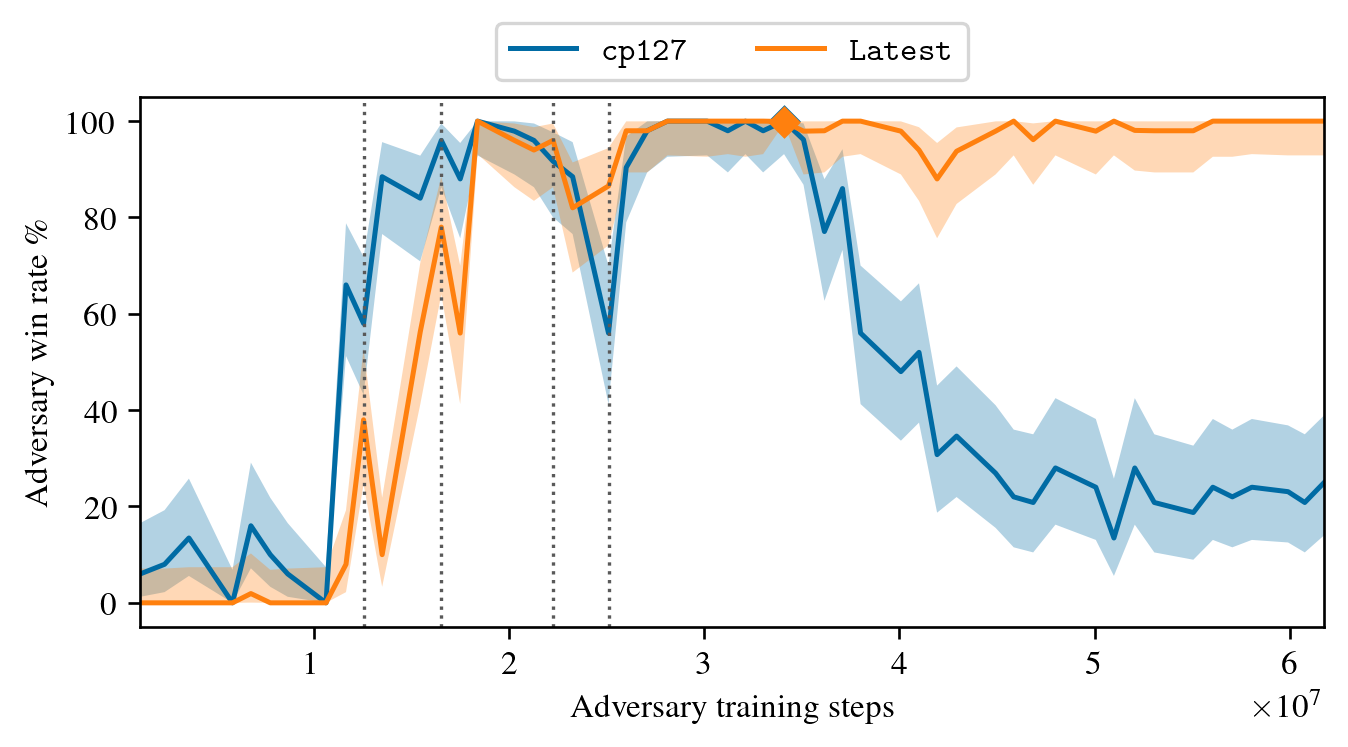

In [6]:
fig, _ = plot_training(
    df,
    victim_name_to_plot_label,
    34090496,
    victim_change_steps,
)
fig.savefig("adv-training.pgf", backend="pgf")

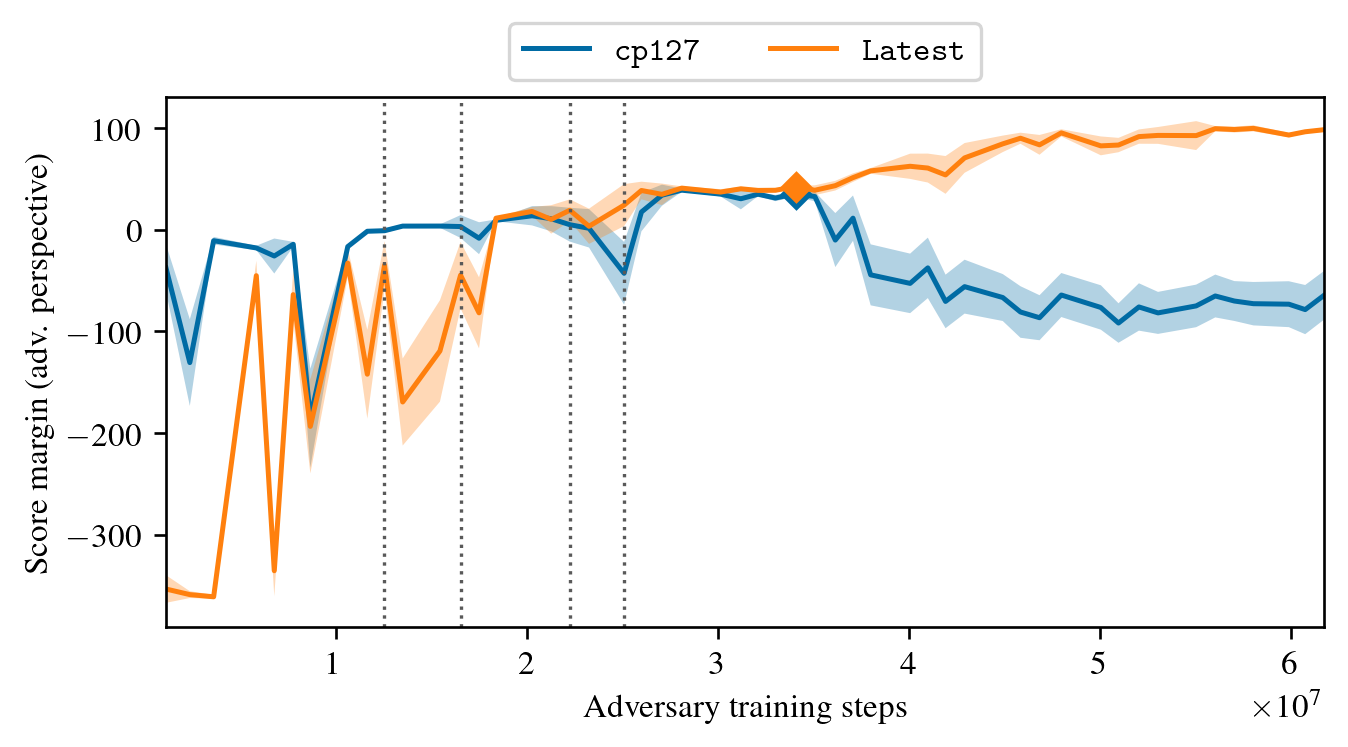

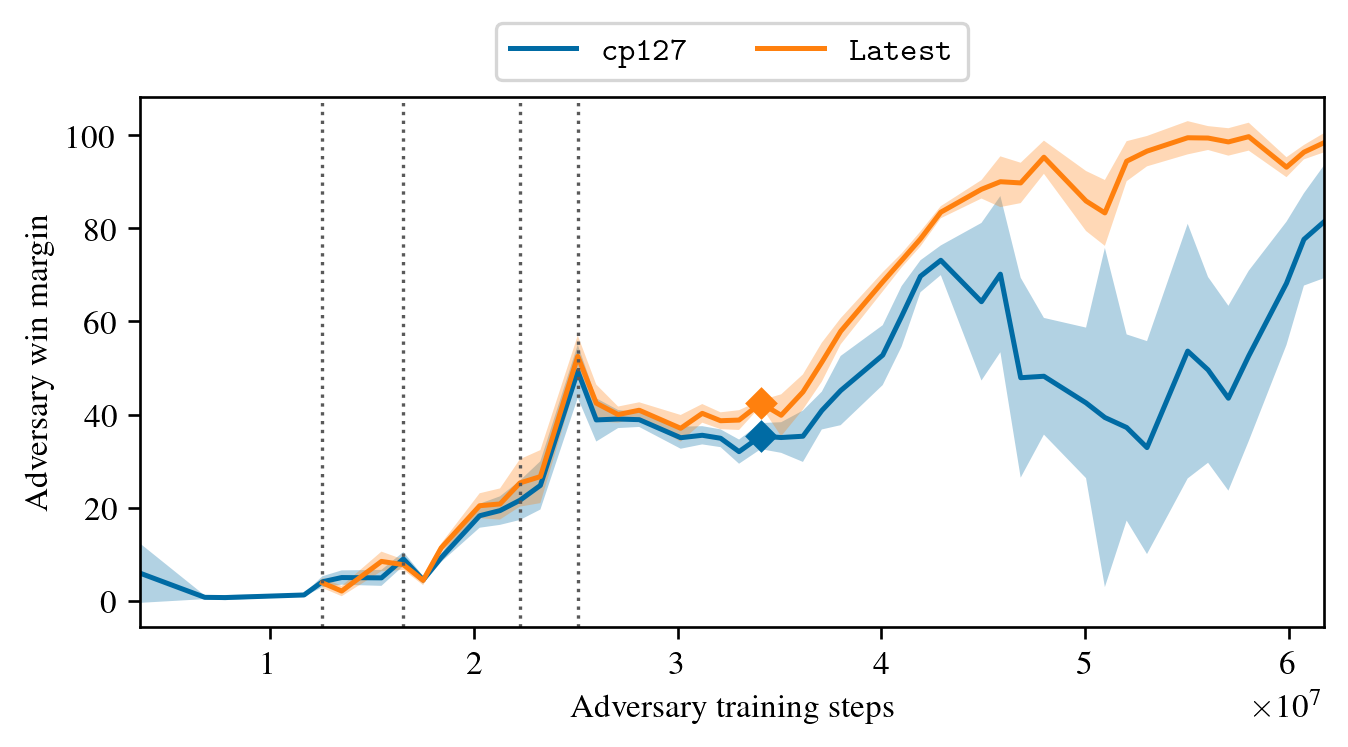

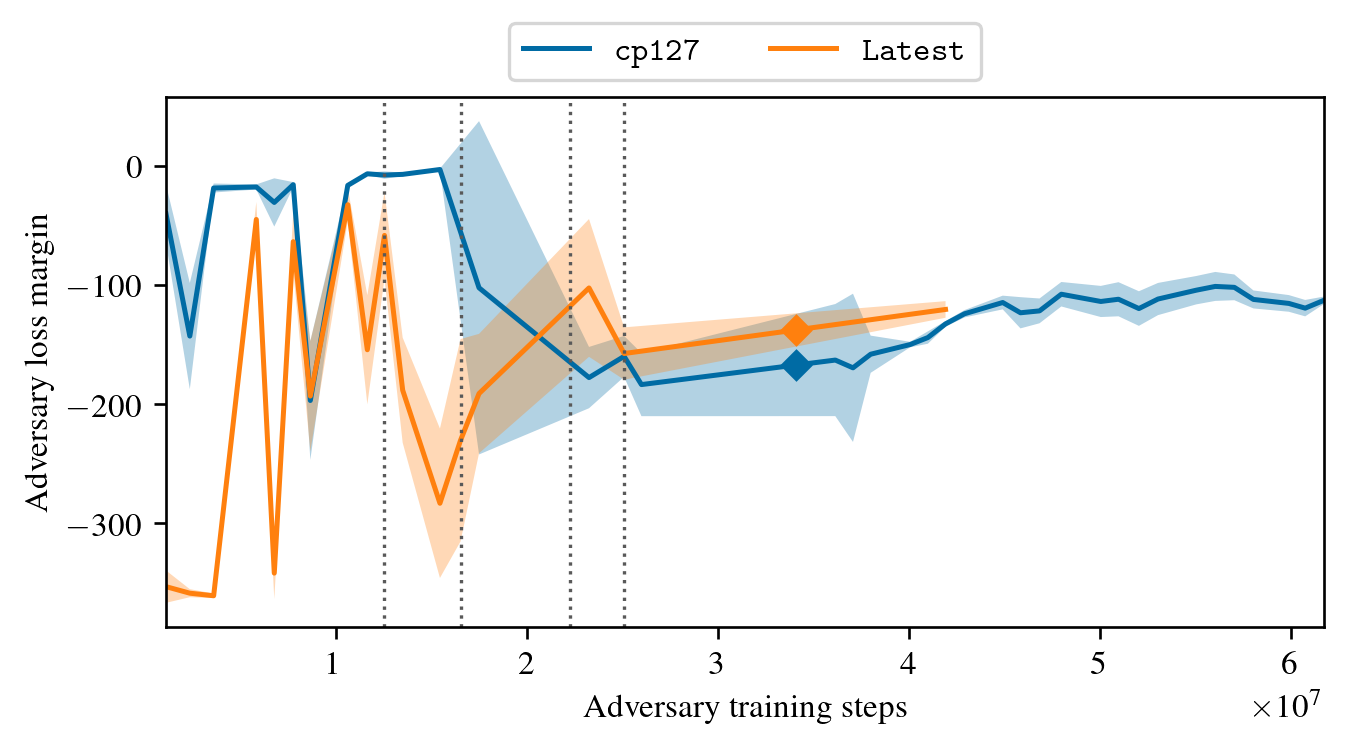

In [5]:
for intended_plot_type in ['scorediff','scorediff_advwin','scorediff_advlose']:
    fig, _ = plot_training(
        df,
        victim_name_to_plot_label,
        34090496,
        victim_change_steps,
        wr_or_scorediff=intended_plot_type
    )
    fig.savefig(f"adv-training-{intended_plot_type}.pgf", backend="pgf")

In [7]:
training_df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/victimplay/ttseng-avoid-pass-alive-coldstart-39-20221025-175949/selfplay"
    ]
)
victim_change_steps = get_victim_change_steps(training_df)
print("Victim change steps:", victim_change_steps)

df = utils.parse_sgfs(
    ["/nas/ucb/k8/go-attack/match/ttseng-hard-adv-checkpoint-sweep-497mil-221115"]
)
print("All victims:", df.victim_name.unique())
victim_name_to_plot_label = {
    "cp39h-v1": r"$\texttt{cp39}_\texttt{def}$",
    "cp127h-v1": r"$\texttt{cp127}_\texttt{def}$",
    "cp505h-v1": r"$\texttt{Latest}_\texttt{def}$",
    "cp505h-v2048": r"$\texttt{Latest}_\texttt{def}$ (2048 visits)",
}

Victim change steps: [0, 30365184, 34502144, 38566400, 87698176, 164908288, 194422784, 198203136, 205049600, 212038912, 218883584, 227013120, 227013120, 230932992, 417232384, 466991360, 486887168, 491808000, 495654912, 499575296, 503639552, 509699584, 516545024, 522673664, 529022720, 534938880, 539786240, 544065792]
All victims: ['cp505h-v2048' 'cp127h-v1' 'cp39h-v1' 'cp505h-v1' 'cp505-v1'
 'cp505-v2048']


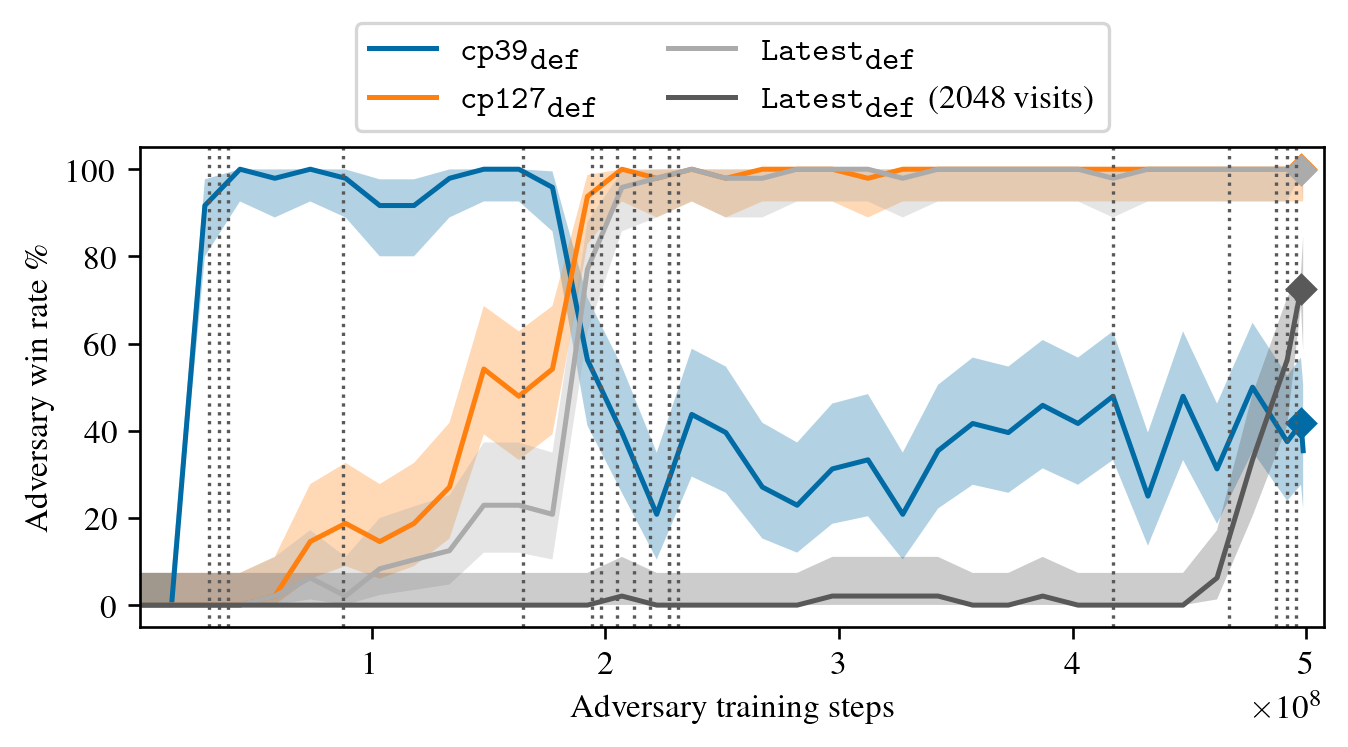

In [8]:
fig, _ = plot_training(
    df,
    victim_name_to_plot_label,
    497721856,
    victim_change_steps,
    legend_ncol=2,
)
fig.savefig("adv-497mil-training-hardened.pgf", backend="pgf")

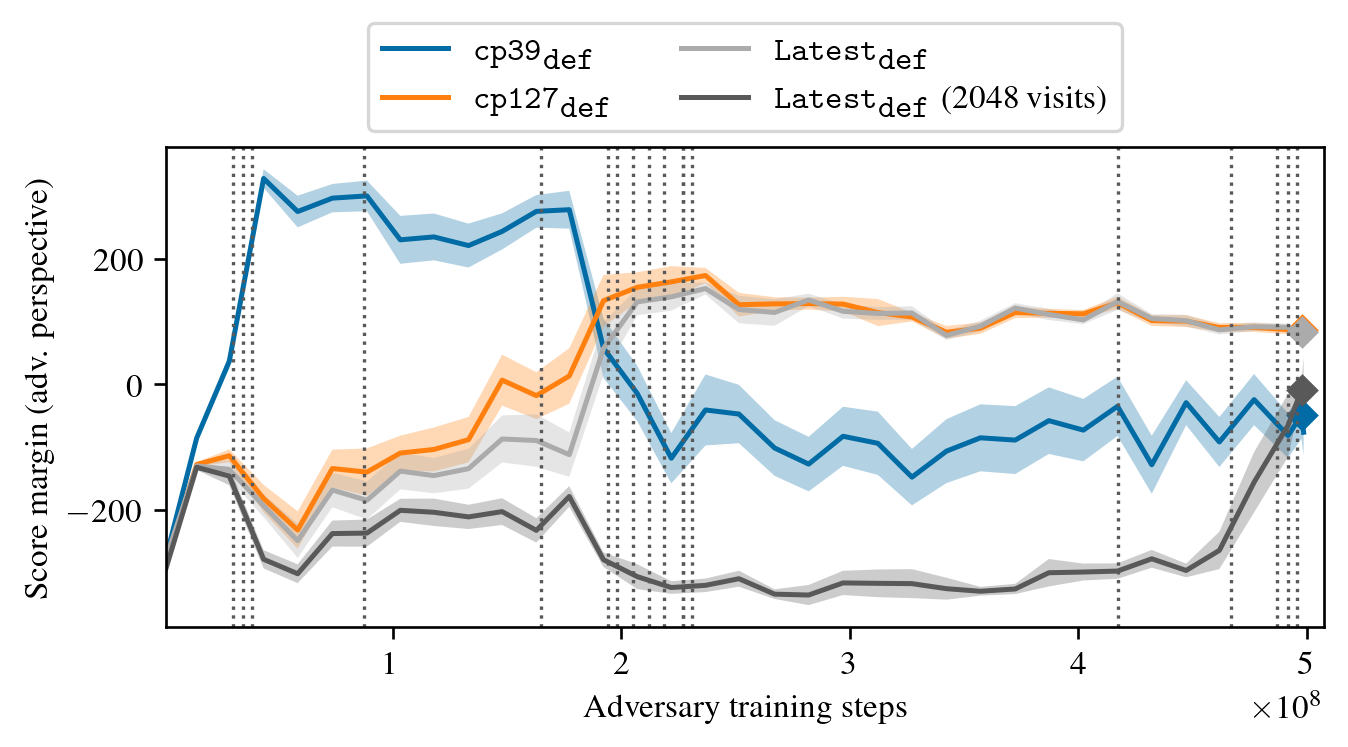

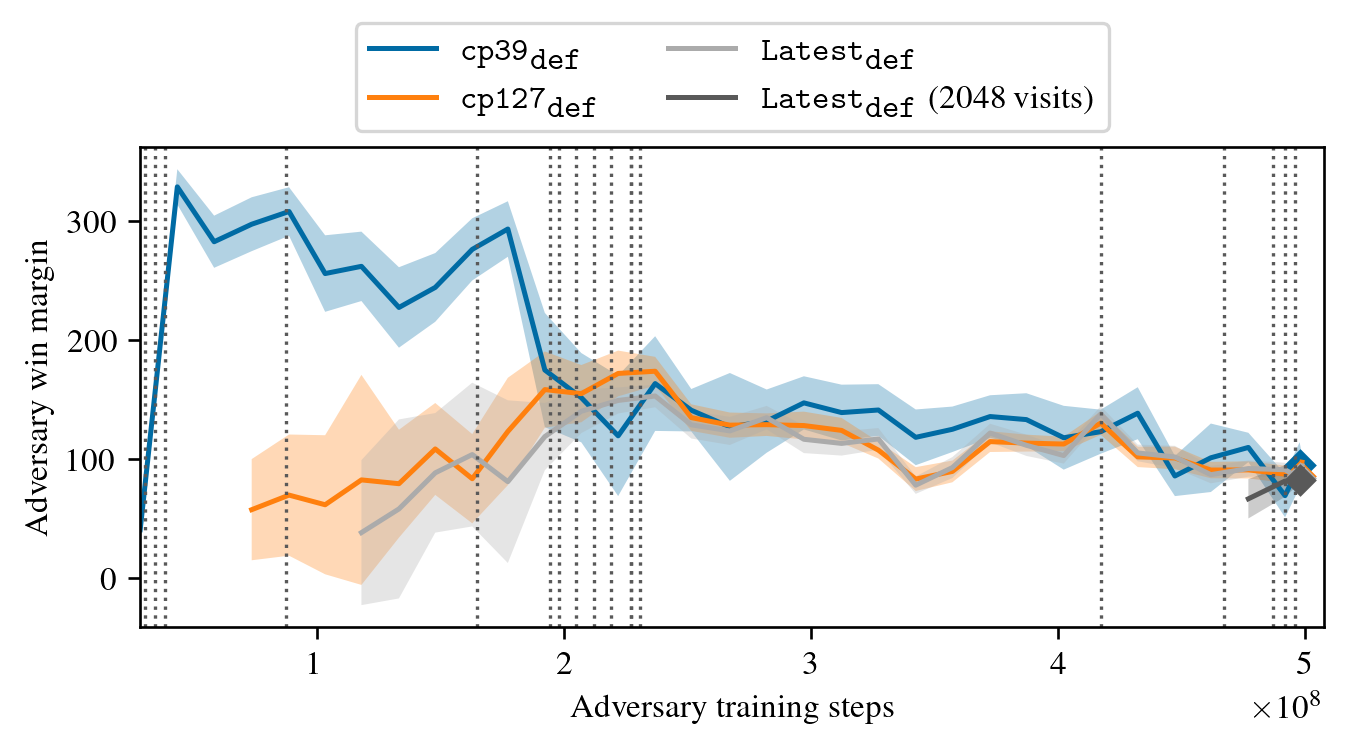

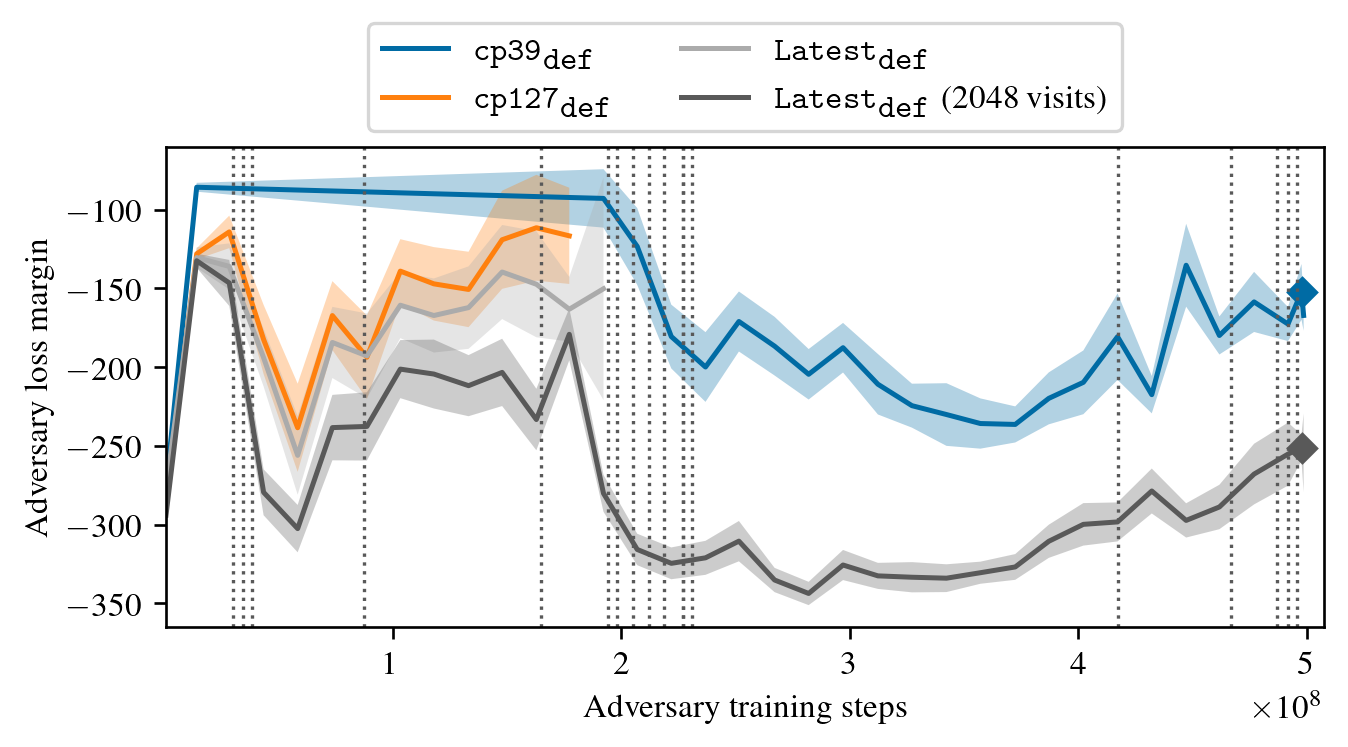

In [9]:
for intended_plot_type in ['scorediff','scorediff_advwin','scorediff_advlose']:
    fig, _ = plot_training(
        df,
        victim_name_to_plot_label,
        497721856,
        victim_change_steps,
        legend_ncol=2,
        wr_or_scorediff=intended_plot_type
    )
    fig.savefig(f"adv-497mil-training-hardened-{intended_plot_type}.pgf", backend="pgf")